In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch.nn as nn
import lightgbm as lgb
from utils import *


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
alldata = data[(data.asin == 'B07MPC7C8G')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(626, 2)

In [4]:
alldata.head(2).append(alldata.tail(2))

,data_date,ordered_units
15976,2019-12-02,434
15940,2019-12-03,70
28672,2021-08-21,60
28854,2021-08-22,67


In [5]:
alldata.ordered_units.mean()

65.51437699680511

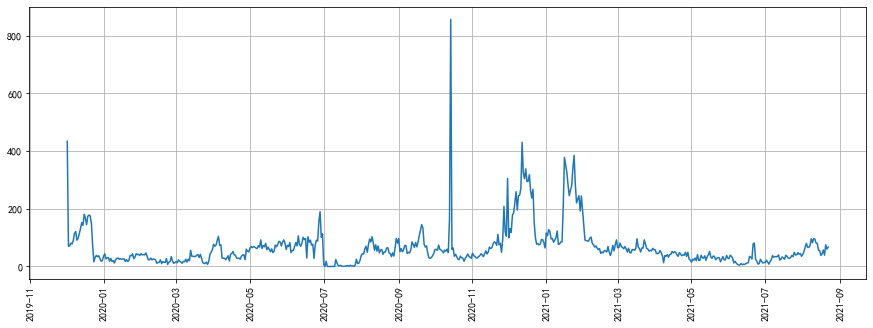

In [6]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)
plt.grid()

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

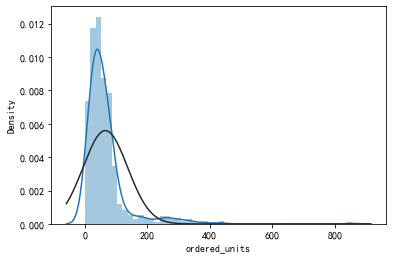

In [6]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [8]:
alldata.ordered_units.skew(), np.log1p(alldata.ordered_units).skew()

(4.151797276485558, -1.0743319706739503)

In [9]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

0.1081354031457522

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

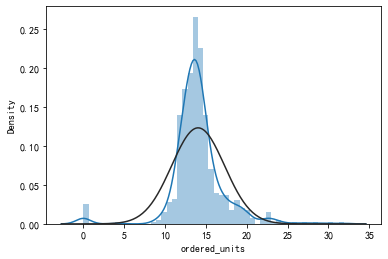

In [10]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [8]:
alldata[alldata.ordered_units <= 0].index

Int64Index([8241, 8163, 8124, 8083, 8044, 8008, 7970, 7930, 7656, 7296], dtype='int64')

In [9]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

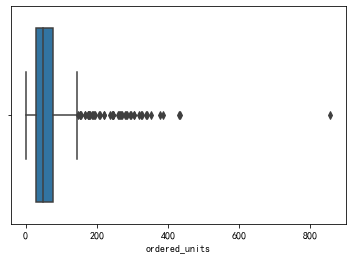

In [10]:
sns.boxplot(alldata.ordered_units)

In [11]:
alldata[alldata.ordered_units > 750].index

Int64Index([3885], dtype='int64')

In [12]:
alldata.drop(alldata[alldata.ordered_units > 750].index, inplace=True)

In [13]:
alldata.shape

(615, 2)

### 缺失值

In [16]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [33]:
def create_feature(df):
    df['weight'] = df.data_date.apply(lambda x: (
        x - pd.to_datetime('2019-12-02')).days)
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [18]:
alldata = create_feature(alldata)

In [19]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15976,434,0,2019,12,2,0,4,49
15940,70,1,2019,12,3,1,4,49
15906,71,2,2019,12,4,2,4,49


In [20]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)

In [21]:
x_train.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
2971,337,2020,11,3,1,4,45
9154,189,2020,6,8,0,2,24


### 编码

In [22]:
weight_cat = list(range(1, 1000))
year_category = [2019, 2020, 2021, 2022]
month_category = list(range(1, 13))
day_category = list(range(1, 32))
weekday_cat = list(range(7))
quarter_cat = [1, 2, 3, 4]
weekofyear_cat = list(range(1, 54))

encoder = OneHotEncoder(sparse=False,
                        categories=[weight_cat, year_category, month_category,
                                    day_category, weekday_cat, quarter_cat, weekofyear_cat],
                        handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((553, 1110), (62, 1110))

## 训练

### sklearn api

In [27]:
ts = time()
print(cross_val_score(xgbr, x_train, y_train, cv=5).mean())
time() - ts

0.32000629278074316


1.9076037406921387

In [23]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, 
                    verbosity=1)

xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:64.90218	validation_1-rmse:89.71648
[1]	validation_0-rmse:52.46609	validation_1-rmse:77.14529
[2]	validation_0-rmse:43.58354	validation_1-rmse:68.36581
[3]	validation_0-rmse:37.51474	validation_1-rmse:60.24598
[4]	validation_0-rmse:34.20521	validation_1-rmse:57.79243
[5]	validation_0-rmse:30.40690	validation_1-rmse:57.47164
[6]	validation_0-rmse:27.88637	validation_1-rmse:55.84566
[7]	validation_0-rmse:26.73168	validation_1-rmse:55.30261
[8]	validation_0-rmse:25.12962	validation_1-rmse:55.37929
[9]	validation_0-rmse:24.37259	validation_1-rmse:54.93452
[10]	validation_0-rmse:23.80167	validation_1-rmse:54.71755
[11]	validation_0-rmse:23.19803	validation_1-rmse:55.16791
[12]	validation_0-rmse:21.37794	validation_1-rmse:53.02930
[13]	validation_0-rmse:20.90505	validation_1-rmse:52.53189
[14]	validation_0-rmse:17.90772	validation_1-rmse:50.41431
[15]	validation_0-rmse:17.45212	validation_1-rmse:50.34656
[16]	validation_0-rmse:16.86551	validation_1-rmse:50.19495
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# 网格搜索
# params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# params_grid = {'max_depth': range(0, 8, 1)}

# params_grid = {'subsample': np.arange(0, 1, 0.05)}
params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

ts = time()
gridCV.fit(x_train, y_train)
print(time() - ts)
gridCV.best_params_, gridCV.best_score_

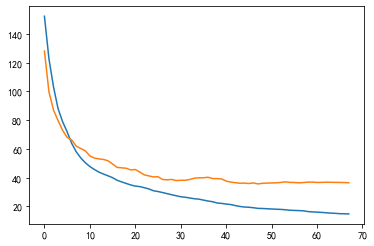

In [28]:
result = xgbr.evals_result()
plt.plot(result['validation_0']['rmse'])
plt.plot(result['validation_1']['rmse'])

## 测试

### sklearn api

In [24]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.883
metrics2: 0.642
r2: 0.655


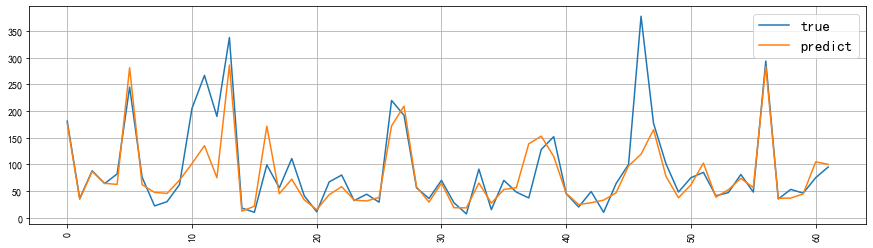

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend(fontsize=15)

In [26]:
alldata.tail()

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
28732,57,625,2021,8,18,2,3,33
28618,39,626,2021,8,19,3,3,33
28550,75,627,2021,8,20,4,3,33
28672,60,628,2021,8,21,5,3,33
28854,67,629,2021,8,22,6,3,33


In [31]:
date_pred = pd.DataFrame({'data_date': pd.date_range('2021-8-23', periods=30)})

In [34]:
create_feature(date_pred)

,weight,year,month,day,weekday,quarter,weekofyear
0,630,2021,8,23,0,3,34
1,631,2021,8,24,1,3,34
2,632,2021,8,25,2,3,34
3,633,2021,8,26,3,3,34
4,634,2021,8,27,4,3,34
5,635,2021,8,28,5,3,34
6,636,2021,8,29,6,3,34
7,637,2021,8,30,0,3,35
8,638,2021,8,31,1,3,35
9,639,2021,9,1,2,3,35


In [35]:
date_pred = encoder.transform(date_pred)

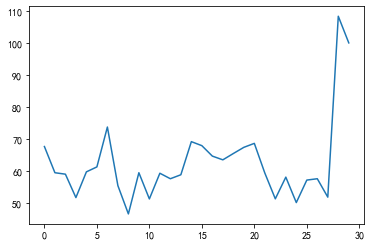

In [36]:
plt.plot(xgbr.predict(date_pred))

In [37]:
from sklearn.model_selection import TimeSeriesSplit

In [38]:
a = np.random.randn(10, 10)

In [39]:
tss = TimeSeriesSplit(n_splits=9)

In [40]:
for i in tss.split(a):
    print(i)

(array([0]), array([1]))
(array([0, 1]), array([2]))
(array([0, 1, 2]), array([3]))
(array([0, 1, 2, 3]), array([4]))
(array([0, 1, 2, 3, 4]), array([5]))
(array([0, 1, 2, 3, 4, 5]), array([6]))
(array([0, 1, 2, 3, 4, 5, 6]), array([7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([8]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([9]))


In [41]:
cross_val_score(xgbr, x_train, y_train, cv=tss, )

array([0.408846  , 0.33701845, 0.51729329, 0.05600082, 0.40083795,
       0.63809845, 0.77533316, 0.80992753, 0.7627919 ])